Transformers are a type of neural network architecture that was introduced in 2017 as a novel way to perform sequence-to-sequence learning, i.e., to transform an input sequence into an output sequence. <br>
<br>
They are well-suited for tasks such as language translation, text generation, and image captioning. <br>
<br>
Transformers consist of two main components: the encoder and the decoder. The encoder processes the input sequence and produces a hidden representation, which is then used by the decoder to generate the output sequence.

### Transformer Encoder

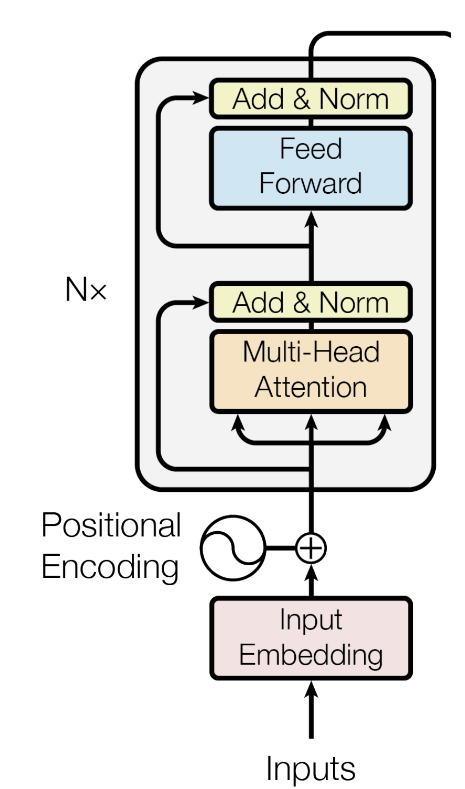

Transformer architecture cannot inherently capture any information about the relative positions of the words in the sequence since it does not make use of recurrence. This information has to be injected by introducing positional encodings to the input embeddings.

**Positional encoding:** to give the model access to word order information, we’re going to add the word’s position in the sentence to each word embedding.<br>
Our input word embeddings will have two components: the usual word vector, which represents the word, and a position vector, which represents the position of the word in the current sentence. 

Suppose you have an input sequence of length  and require the position of the  object within this sequence. The positional encoding is given by sine and cosine functions of varying frequencies:

\begin{equation}
PE_{(pos, 2i)} = \sin(pos/10000^{2i/d_{model}}) \\
PE_{(pos, 2i+1)} = \cos(pos/10000^{2i/d_{model}})
\end{equation}



Where:<br>
pos is the position of the token in the sequence<br>
i is the index of the dimension in the embedding vector (starting from 0)<br>
d is the dimensionality of the embedding vector <br>
PE is the positional encoding value for the token at position pos and dimension i

**Transformer encoder** consists of several layers, and each layer has **two sub-layers:** a multi-head self-attention mechanism and a fully connected feed-forward network.

**Multi-head self-attention:** mechanism allows the model to focus on different parts of the input sequence during the encoding process. It is composed of several scaled dot-product attention sub-layers. Each sub-layer has three inputs: the queries, keys, and values, which are obtained by applying different linear projections to the input sequence. The queries and keys are used to compute a similarity score between each pair of tokens in the input sequence, and the values are used to weight the importance of each token in the sequence based on its similarity to the other tokens. The resulting weighted values are then combined to produce the final output.

The **fully connected feed-forward network** consists of two linear transformations separated by a non-linear activation function, such as ReLU. <br>

feedforward networks after the multi-head self-attention layer in the Transformer encoder allow for more complex and non-linear transformations of the output of the attention layer.

The self-attention layer generates a set of weighted vectors that encode the importance of different parts of the input sequence with respect to each other. However, this output is still a linear combination of the input sequence and its learned representations, which may not capture all of the complex interactions between the different tokens.

Furthermore, each of these two sublayers has a **residual connection** around it.<br>
A residual connection, also known as a skip connection, is a shortcut connection that **allows the input to directly flow to the output of a layer**, instead of passing through multiple non-linear transformations. The output of the layer is added element-wise to the input of the layer, and the sum is passed through a normalization layer. This helps to ensure that the information from the original input is not lost during the forward propagation through the neural network. <br>

In the case of the Transformer encoder, the **residual connection ensures that the original input representation is preserved and combined with the output of the self-attention layer and the feedforward neural network layer**. This helps to prevent the information from being lost or distorted during the weight adjustment through the encoder layers, and allows the network to better learn the representation of the input sequence.

Each sublayer is also succeeded by a normalization layer,which normalizes the sum computed between the sublayer input, x, and the output generated by the sublayer itself, sublayer(x):<br>
layernorm(x + sublayer(x))

The **normalization layer** is applied after each sub-layer, including after the multi-head self-attention layer and after the feedforward network. This helps to prevent the activations of the neurons from getting too large or too small. <br>
The normalization layer achieves this by scaling the activations of each neuron to have zero mean and unit variance across the training data. This allows the model to learn the optimal weight values for each neuron, leading to faster and more stable convergence during training.

In [ ]:
import tensorflow as tf
from keras import layers
from keras.datasets import imdb
from keras.utils import pad_sequences

In [ ]:
# Load the IMDB dataset and prepare it for training
vocab_size = 20000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post')

17464789/17464789 [==============================] - 1s 0us/step


In [ ]:
# Define the Transformer model
embedding_dim = 32
num_heads = 2
dff = 64
num_layers = 2

In [ ]:
#input embedding

inputs = layers.Input(shape=(maxlen,)) #maxlen is the maximum length of a sequence in the input data
embedding_layer = layers.Embedding(vocab_size, embedding_dim)(inputs) #creates an embedding layer that maps each token in the input sequence to a dense vector of size embedding_dim

positional_encoding_layer = layers.Embedding(input_dim=maxlen, output_dim=embedding_dim)(tf.range(start=0, limit=maxlen, delta=1))
#The input_dim argument specifies the maximum position in the input sequence 
#the output_dim argument specifies the size of the dense vectors
#The tf.range() function is used to create a 1D tensor of shape (maxlen,) that contains the integer values from 0 to maxlen-1, 
#which is used as the input to the Embedding layer. 
embedding_layer = embedding_layer + positional_encoding_layer


positional_encoding_layer is using the Embedding layer from Keras to learn the positional embeddings directly. The positional encoding layer generates a maxlen x embedding_dim matrix, where each row represents the positional encoding for that position.<br>
The values for the positional encodings are not directly set, but are learned by the model during training. <br>
The output of the positional_encoding_layer is then added to the word embeddings in the embedding_layer using the + operator, to produce the final input to the Transformer model.

In [ ]:
encoder_outputs = embedding_layer #The input sequence is first embedded using an embedding layer. The output of this layer is stored in encoder_outputs.

for i in range(num_layers): #The encoder consists of multiple identical layers. Here, num_layers =2

    multi_head_attention_layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)#The first sub-layer of the Transformer encoder
    #num_heads and key_dim are the number of attention heads and the dimensionality of the key vectors

    norm1 = layers.LayerNormalization(epsilon=1e-6)(encoder_outputs)#The input to the multi-head self-attention layer is normalized using a layer normalization layer
    attention_output = multi_head_attention_layer(norm1, norm1, norm1) #The multi-head self-attention layer takes in the normalized input three times (query, key, and value)

    add1 = layers.Add()([encoder_outputs, attention_output]) #The attention output is added to the input (residual connection)

    norm2 = layers.LayerNormalization(epsilon=1e-6)(add1) #The output of the previous step is then normalized again

    ff_layer = layers.Dense(units=dff, activation='relu')(norm2) #The second sub-layer of the Transformer encoder is a feed-forward network
    ff_layer = layers.Dense(units=embedding_dim)(ff_layer)

    add2 = layers.Add()([norm2, ff_layer]) #The output of the linear projection layer is added to the output of the normalization layer (residual connection)
    encoder_outputs = add2 #The output of the previous step is then used as the input to the next layer.

In [ ]:
# Use the final encoder output as the input to the classification head
outputs = layers.GlobalAveragePooling1D()(encoder_outputs)
outputs = layers.Dense(1, activation='sigmoid')(outputs)

In [ ]:
# Compile and train the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
782/782 [==============================] - 272s 348ms/step - loss: 0.0790 - accuracy: 0.9735 - val_loss: 0.4913 - val_accuracy: 0.8401
Epoch 2/5
782/782 [==============================] - 270s 345ms/step - loss: 0.0479 - accuracy: 0.9834 - val_loss: 0.5561 - val_accuracy: 0.8370
Epoch 3/5
782/782 [==============================] - 267s 342ms/step - loss: 0.0327 - accuracy: 0.9889 - val_loss: 0.6334 - val_accuracy: 0.8450
Epoch 4/5
782/782 [==============================] - 251s 321ms/step - loss: 0.0223 - accuracy: 0.9926 - val_loss: 0.5506 - val_accuracy: 0.8446
Epoch 5/5
782/782 [==============================] - 248s 317ms/step - loss: 0.0176 - accuracy: 0.9942 - val_loss: 0.7906 - val_accuracy: 0.8391
